### Simple Grad-CAM implementaion for VGG16
(standalone)

Developed by Nick Haliwell

In [1]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg16_bn
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import cv2

In [2]:
imagenet_mean = [ 0.485, 0.456, 0.406 ]
imagenet_std  = [ 0.229, 0.224, 0.225 ]

test_trans = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean = imagenet_mean,
                             std = imagenet_std),
    ])
    
# define a 1 image dataset
dataset = datasets.ImageFolder(root='./data/Humans and Animals/', transform=test_trans)

# define the dataloader to load that single image
dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)

In [3]:
class MonaLia_VGG(nn.Module):
    def __init__(self, class_count, param_file=None):
        super(MonaLia_VGG, self).__init__()
        
        # get the pretrained VGG16 network
        self.vgg = vgg16_bn(pretrained=(param_file is None))
        
        # modify the last layer 
        self.vgg.classifier[-1] = nn.Linear(self.vgg.classifier[-1].in_features, class_count) 
        
        # read trained parameters
        if(param_file is not None):
            self.vgg.load_state_dict(torch.load(param_file, map_location=lambda storage, loc: storage))
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:43]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg16
        self.classifier = self.vgg.classifier
        
        # placeholder for the gradients
        self.gradients = None
  
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

In [4]:
model = MonaLia_VGG(class_count = 2, param_file = 'pth\VGG16_bn_Joconde_human_vs_animals.1000.16.pth')
#model = MonaLia_VGG(class_count = 1000, param_file = None)

In [5]:
def image_tensor_to_np(image_tensor,
                       norm_mean = [0.0, 0.0, 0.0],
                       norm_std = [1.0, 1.0, 1.0]):
    """
    Helper function to convert image tensor to numpy array for use in image display 
    """
    image_np = image_tensor.numpy()[0,:,:,:].transpose(1,2,0)
    image_np = image_np * norm_std + norm_mean
    image_np = np.clip(image_np, 0, 1)
    return image_np

In [6]:
model.eval()

MonaLia_VGG(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, di

In [7]:
def run_gradcam(img, counterfact = False):
    
    pred = model(img).max()
    
    pred.backward()

    gradients = model.get_activations_gradient()
    
    if counterfact:
        
        gradients *= -1
        
    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # get the activations of the last convolutional layer
    activations = model.get_activations(img).detach()

    n_channels = gradients.shape[1]
    
    # weight the channels by corresponding gradients
    for i in range(n_channels):

        activations[:, i, :, :] *= pooled_gradients[i]

    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()

    # relu on top of the heatmap
    # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
    heatmap = np.maximum(heatmap, 0)

    heatmap = cv2.resize(np.float32(heatmap), dsize=(224,224))
    
    return heatmap

In [8]:
list_dataloader = list(dataloader)

In [9]:
imgs = []
originals = []
heatmaps = []

In [10]:
for img, label in list_dataloader:
    
    imgs.append(img)
    
    original = image_tensor_to_np(img , imagenet_mean, imagenet_std)
    originals.append(original)
    
    heatmap = run_gradcam(img, counterfact=False)
    heatmaps.append(heatmap)

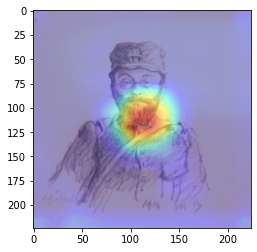

In [16]:
plt.imshow(originals[0])
plt.imshow(heatmaps[0], alpha = 0.4, cmap='jet')